# Imports

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

---

# Ultimas pruebas realizadas

#### Datos con ventanas de 4 dias, los features de auctions se mantienen, cambian los de events clicks e installs dejando pocos de cada uno

In [2]:
train = pd.read_pickle("../../armado_datos/train_nuevo_completo")

In [3]:
(train["target"] == 259200.0).sum() / len(train)

0.28187048468905734

In [7]:
train_maximos = train[train["target"] == train["target"].max()]

In [8]:
len(train_maximos)

362497

#### DIferentes nombres de datasets con los que probé:

##### __train__ : Dataset completo

##### __train_red__ : Me quede con todos los que tenian valores maximos y agrege una muestra random de 400 mil de las que tenian valor antes de los 3 dias, la prueba no dio bien, igual que siempre

##### __train_disminuido__ : Dataset filtrado con distintos valores pidiendo cierta cantidad de nulos, el que más mejora dependiendo el valor elegidoDistintos valores con los que fui jugando para filtrar


In [10]:
train_red = train[~(train["target"] == train["target"].max())].sample(400000,random_state = 1)

In [12]:
train_red = train_red.append(train_maximos)

In [13]:
train_red.fillna(0,inplace = True)

---

#### Quedarme con los que tienen menos datos vacios de events, installs y clicks

In [17]:
cantidad_columnas = len(train.columns) - 1

In [23]:
train.fillna(0,inplace = True)

In [24]:
train["cant_nulos"] = train.apply(lambda x: cantidad_columnas - (np.count_nonzero((x.to_numpy()))) ,axis = 1)

In [25]:
cantidad_columnas

57

In [26]:
train["cant_nulos"].max()

48

In [22]:
len(train)

1286041

In [30]:
train["cant_nulos"].value_counts().head(10)

46    126119
40     96885
42     96551
41     95111
39     93945
43     88216
38     84699
37     75023
36     66030
35     56705
Name: cant_nulos, dtype: int64

In [49]:
len(train[train["cant_nulos"] < 38])

525807

In [50]:
train_disminuido = train[train["cant_nulos"] < 38]

## Porcentaje de valores maximos dentro de lo disminuido

In [51]:
len(train_disminuido[train_disminuido["target"] == train["target"].max()]) / len(train_disminuido) * 100

11.755263813528538

---

### Prueba: 
#### Los resultados de cada prueba estan anotados como comentario

In [52]:
X, y = train_disminuido.drop("target",axis = 1), train_disminuido["target"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':6,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 0.7,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.1}


num_round = 5000
stopping = 20
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)

#reducido 
#Stopping. Best iteration:
#[317]	train-rmse:88534.2	test-rmse:89883.8


#Completo sin rellenar los nan con 0
#Stopping. Best iteration:
#[598]	train-rmse:87166.5	test-rmse:88788


#Filtrado por cantidad de 0 menor a 42 sobre maximo de 48
#len 896 mil 
#Stopping. Best iteration:
#[306]	train-rmse:84055.4	test-rmse:85194.5


#Filtrados menor a 40
#len 704 mil
#[323]	train-rmse:79957.7	test-rmse:81724.4


#Filtrados a menor de 41
#len 801 mil
#[404]	train-rmse:81918.7	test-rmse:83678.8


#Filtrados menor a 39
#len 610 mil
#[267]	train-rmse:77538.2	test-rmse:79137.7

#Filtrados menor a 38
#len 525 mil
#[217]	train-rmse:74849	test-rmse:76739.9

[0]	train-rmse:107314	test-rmse:107847
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:102361	test-rmse:102884
[2]	train-rmse:98161.9	test-rmse:98668.9
[3]	train-rmse:94855.1	test-rmse:95359.6
[4]	train-rmse:91804.3	test-rmse:92296.6
[5]	train-rmse:89240.2	test-rmse:89729.1
[6]	train-rmse:87112.4	test-rmse:87597.8
[7]	train-rmse:85341.5	test-rmse:85820.3
[8]	train-rmse:83851.1	test-rmse:84325.1
[9]	train-rmse:82621.7	test-rmse:83099.1
[10]	train-rmse:81597.4	test-rmse:82067.9
[11]	train-rmse:80751.4	test-rmse:81226.3
[12]	train-rmse:80051	test-rmse:80529.3
[13]	train-rmse:79480.2	test-rmse:79963.7
[14]	train-rmse:78998.1	test-rmse:79486.9
[15]	train-rmse:78601.4	test-rmse:79094.5
[16]	train-rmse:78264.1	test-rmse:78762.7
[17]	train-rmse:77976.2	test-rmse:78482.8
[18]	train-rmse:77742.4	test-rmse:78258.9
[19]	train-rmse:77565.5	test-rmse:78093.5
[20]	train-rmse:77395.9	test-rmse

---

# Prueba para conversion

In [2]:
train = pd.read_pickle("../../armado_datos/train_completo_installs")

In [5]:
len(train)

1050344

In [6]:
X, y = train.drop("target",axis = 1), train["target"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':6,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 0.7,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.1}


num_round = 5000
stopping = 20
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)

# Datos completos
#[114]	train-rmse:56684.6	test-rmse:57113
#Stopping. Best iteration:
#[94]	train-rmse:56717.6	test-rmse:57109.4

/home/pelozo/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:191772	test-rmse:191548
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:174343	test-rmse:174176
[2]	train-rmse:158874	test-rmse:158714
[3]	train-rmse:145123	test-rmse:144973
[4]	train-rmse:132942	test-rmse:132823
[5]	train-rmse:122194	test-rmse:122092
[6]	train-rmse:112749	test-rmse:112659
[7]	train-rmse:104462	test-rmse:104389
[8]	train-rmse:97228.8	test-rmse:97187.4
[9]	train-rmse:90963.4	test-rmse:90927.3
[10]	train-rmse:85537	test-rmse:85526.4
[11]	train-rmse:80885.4	test-rmse:80891.6
[12]	train-rmse:76912.1	test-rmse:76934.9
[13]	train-rmse:73525.7	test-rmse:73570.7
[14]	train-rmse:70670	test-rmse:70730.2
[15]	train-rmse:68266.6	test-rmse:68343.3
[16]	train-rmse:66255	test-rmse:66349.6
[17]	train-rmse:64575	test-rmse:64691.5
[18]	train-rmse:63188.3	test-rmse:63316
[19]	train-rmse:62037.4	test-rmse:62179.9
[20]	train-rmse:61088.8	test-rmse:61244.8
[21]	train-

In [11]:
magitrain = train

[07:46:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 57083.887321821305


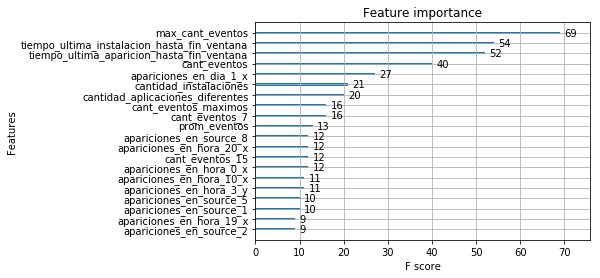

In [12]:
from xgboost import XGBRegressor, plot_importance
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from math import sqrt

X, y = magitrain.drop("target",axis = 1), magitrain["target"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=0)

# fit model on all training data
model = XGBRegressor(n_jobs=6)
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
print("RMSE: {}".format(sqrt(rmse)))

plot_importance(model, max_num_features=20)
pyplot.show()

In [15]:
comparacion = pd.DataFrame({"valor_real":y_test,"valor_predicho":y_pred})

In [16]:
comparacion["diferencia"] = abs(comparacion["valor_real"] - comparacion["valor_predicho"])

---

## Prueba todos los datos para auctions

In [ ]:
train = pd.read_pickle("../../armado_datos/train_completo_auctions")

In [6]:
X, y = train.drop("target",axis = 1), train["target"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':6,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 0.7,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.1}


num_round = 5000
stopping = 20
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)

# Datos completos
#[114]	train-rmse:56684.6	test-rmse:57113
#Stopping. Best iteration:
#[94]	train-rmse:56717.6	test-rmse:57109.4

/home/pelozo/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:148649	test-rmse:148596
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:139417	test-rmse:139380
[2]	train-rmse:131464	test-rmse:131452
[3]	train-rmse:124609	test-rmse:124634
[4]	train-rmse:118806	test-rmse:118842
[5]	train-rmse:113843	test-rmse:113907
[6]	train-rmse:109661	test-rmse:109752
[7]	train-rmse:106127	test-rmse:106244
[8]	train-rmse:103173	test-rmse:103311
[9]	train-rmse:100705	test-rmse:100858
[10]	train-rmse:98657.3	test-rmse:98827.8
[11]	train-rmse:96952.1	test-rmse:97133.8
[12]	train-rmse:95543.2	test-rmse:95736.3
[13]	train-rmse:94383.2	test-rmse:94588.7
[14]	train-rmse:93429.6	test-rmse:93645.9
[15]	train-rmse:92636.6	test-rmse:92864.8
[16]	train-rmse:91979.6	test-rmse:92220.6
[17]	train-rmse:91440.5	test-rmse:91689.4
[18]	train-rmse:90996.2	test-rmse:91251.5
[19]	train-rmse:90630.4	test-rmse:90895.5
[20]	train-rmse:90326.8	test-rmse:90599.6
[21]	

---

## Prueba de todos los datos para auctions y con outer join (EXPLOTA)

In [2]:
train = pd.read_pickle("../../armado_datos/train_completo_auctions_outer")

In [3]:
len(train)

1734598

In [4]:
X, y = train.drop("target",axis = 1), train["target"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':6,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 0.7,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.1}


num_round = 5000
stopping = 20
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)

# Datos completos
#[114]	train-rmse:56684.6	test-rmse:57113
#Stopping. Best iteration:
#[94]	train-rmse:56717.6	test-rmse:57109.4

/home/pelozo/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:nan	test-rmse:nan
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:nan	test-rmse:nan
[2]	train-rmse:nan	test-rmse:nan
[3]	train-rmse:nan	test-rmse:nan
[4]	train-rmse:nan	test-rmse:nan
[5]	train-rmse:nan	test-rmse:nan
[6]	train-rmse:nan	test-rmse:nan
[7]	train-rmse:nan	test-rmse:nan
[8]	train-rmse:nan	test-rmse:nan
[9]	train-rmse:nan	test-rmse:nan
[10]	train-rmse:nan	test-rmse:nan
[11]	train-rmse:nan	test-rmse:nan
[12]	train-rmse:nan	test-rmse:nan
[13]	train-rmse:nan	test-rmse:nan
[14]	train-rmse:nan	test-rmse:nan
[15]	train-rmse:nan	test-rmse:nan
[16]	train-rmse:nan	test-rmse:nan
[17]	train-rmse:nan	test-rmse:nan
[18]	train-rmse:nan	test-rmse:nan
[19]	train-rmse:nan	test-rmse:nan
[20]	train-rmse:nan	test-rmse:nan


KeyError: 'best_msg'

---

## Prueba de PCA (No mejoró)

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
train = pd.read_pickle("../../armado_datos/train_nuevo_completo")

In [4]:
target = train["target"]

In [11]:
train.fillna(0,inplace = True)

In [5]:
train.drop("target",axis =1,inplace = True)

In [12]:
len(train.columns)

57

In [13]:
sc = StandardScaler()
train_red = sc.fit_transform(train)

In [14]:
pca = PCA()

In [15]:
train_red = pca.fit_transform(train_red)

In [16]:
explained_variance = pca.explained_variance_ratio_

In [17]:
len(explained_variance)

57

Text(0.5, 1.0, 'Varianza del conjunto de datos')

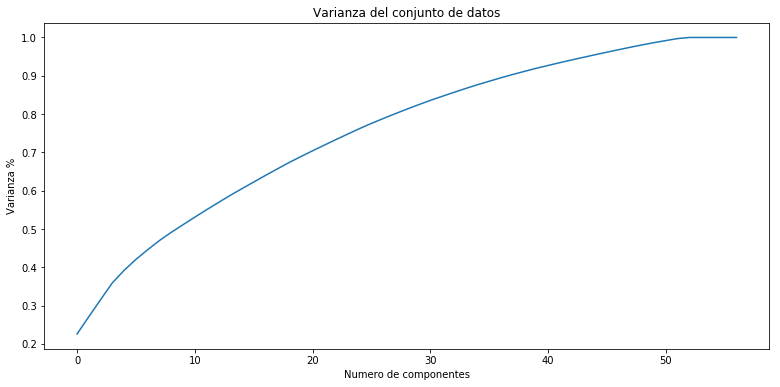

In [18]:
datos = np.cumsum(explained_variance)
#maximo = datos.max()

plt.figure(figsize = (13,6))
plt.plot(datos)
#plt.plot(maximo,marker = "o")
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza %")
#plt.xticks(np.arange(47))

plt.title("Varianza del conjunto de datos")

In [19]:
pd.DataFrame(datos).tail(12)

,0
45,0.961580
46,0.968124
47,0.974540
48,0.980678
49,0.986535
50,0.991887
51,0.997093
52,1.000000
53,1.000000
54,1.000000


In [20]:
dimensiones = 51

In [21]:
train_red = sc.fit_transform(train)

In [22]:
pca = PCA(n_components = dimensiones)

In [23]:
train_red = pca.fit_transform(train_red)


In [24]:
train_red = pd.DataFrame(train_red)

In [25]:
train_red.set_index(train.index,inplace = True)

In [26]:
train_red["target"] = target

In [27]:
train_red.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,target
device_id,,,,,,,,,,,,,,,,,,,,,
1826643666390887030,3.029708,-0.952875,-0.900757,-0.570948,-1.214764,-1.880975,0.754442,-0.017549,2.164250,-0.178239,...,-0.410869,0.886306,-3.668756,-1.055747,1.068537,-0.881789,0.389737,0.013890,1.006452,75658.343525
7037174172278258682,7.368170,-1.614197,-1.610243,-1.873666,-1.169123,-0.422430,2.073419,-0.763951,1.549227,-0.520047,...,0.665803,0.574586,1.094853,-0.082026,-0.503823,-1.733438,1.403036,0.793636,0.248385,135.824498
3392065368947589877,12.883611,1.979601,3.743669,0.928535,-4.169302,-3.285090,-2.707817,2.212245,1.927350,-0.609984,...,-1.868608,-0.983807,1.198628,0.031857,1.019880,1.424889,-1.354964,0.481607,1.132388,234266.865041
1228982273563226229,38.125136,-7.504183,-9.983208,-9.642790,-9.569863,0.564173,-1.671473,-1.102302,-1.793512,-2.168370,...,-5.615650,1.688741,-0.183203,-0.159803,-6.248659,0.099539,-3.964393,-0.492863,-2.652984,2363.081608
4123059034628125459,-0.883740,0.800245,0.548252,-0.966809,1.575581,-1.908438,-0.222116,0.110548,-0.125854,-2.224515,...,-0.162291,0.105687,-0.100333,0.024281,-0.007887,-0.011536,0.093561,0.016502,0.094006,147350.860399


#### Prueba

In [29]:
X, y = train_red.drop("target",axis = 1), train_red["target"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':6,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 0.7,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.1}


num_round = 5000
stopping = 20
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)


# Reducido con PCA 51 dimensiones completo
#

/home/pelozo/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:148868	test-rmse:148810
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:139936	test-rmse:139904
[2]	train-rmse:132136	test-rmse:132135
[3]	train-rmse:125497	test-rmse:125533
[4]	train-rmse:119869	test-rmse:119911
[5]	train-rmse:114998	test-rmse:115058
[6]	train-rmse:110860	test-rmse:110951
[7]	train-rmse:107391	test-rmse:107504
[8]	train-rmse:104476	test-rmse:104611
[9]	train-rmse:102093	test-rmse:102253
[10]	train-rmse:100059	test-rmse:100239
[11]	train-rmse:98352.9	test-rmse:98555
[12]	train-rmse:96950	test-rmse:97169.8
[13]	train-rmse:95797	test-rmse:96035.8
[14]	train-rmse:94872.6	test-rmse:95127.1
[15]	train-rmse:94062.1	test-rmse:94330.3
[16]	train-rmse:93392.6	test-rmse:93676.9
[17]	train-rmse:92843.5	test-rmse:93137.9
[18]	train-rmse:92400.9	test-rmse:92708.6
[19]	train-rmse:92023.7	test-rmse:92342.7
[20]	train-rmse:91699.7	test-rmse:92026.7
[21]	train-rm

### No mejora

---

## PRUEBAS VIEJAS

----

# Prueba con 1 modelo y datos de events- auctions

In [2]:
train = pd.DataFrame()

for ventana_nro in range(1,6):
    
    features = pd.read_pickle("../../features/auctions_train_ventana_{}.pkl".format(ventana_nro))
#    features_clicks = pd.read_pickle("../../features/clicks_train_ventana_{}.pkl".format(ventana_nro))
    features_events = pd.read_pickle("../../features/events_train_ventana_{}.pkl".format(ventana_nro))
    targets = pd.read_pickle("../../targets/targets_ventana_{}_auctions.pkl".format(ventana_nro))
 

    

    targets = targets.merge(features, how = 'left', left_index=True, right_index=True)
    


#    targets = targets.merge(features_clicks,left_index = True, right_index = True)
  

    targets = targets.merge(features_events,how = 'left', left_index = True, right_index = True)
    
    train = train.append(targets)
   


In [3]:
len(train)

1611351

In [4]:
train.fillna(-1,inplace = True )
ultima_col = train.columns[-1]
train[["target",ultima_col]] = train[[ultima_col,"target"]]
train.rename(columns = {"target":ultima_col,ultima_col:"target"},inplace = True)

In [8]:
magitrain = train


/home/pelozo/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:28:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 89782.76914941357


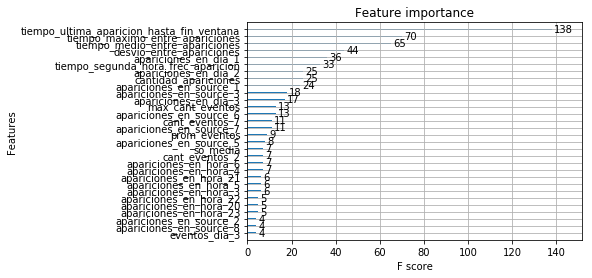

In [48]:
from xgboost import XGBRegressor, plot_importance
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from math import sqrt

X, y = magitrain.iloc[:,:-1], magitrain.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=0)

# fit model on all training data
model = XGBRegressor(n_jobs=6)
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
print("RMSE: {}".format(sqrt(rmse)))

plot_importance(model, max_num_features=30)
pyplot.show()

In [50]:
pred = pd.DataFrame(y_pred)

In [15]:
minimo = train["target"].min()

In [16]:
maximo = train["target"].max()

In [49]:
def corregir(x):
    if x < 0: 
        return minimo
    elif x > maximo:
        return maximo
    return x

In [52]:
pred_corregido = pred[0].apply(lambda x: corregir(x))

In [53]:
rmse = mean_squared_error(y_test, pred_corregido)
print("RMSE: {}".format(sqrt(rmse)))


RMSE: 89782.22220344526


#### No cambia nada

## Comparacion entre valores reales y las predicciones

In [92]:
predicciones = pd.DataFrame(y_pred)

In [93]:
predicciones.rename(columns = {0:"predicciones"},inplace = True)

In [94]:
predicciones.min()

predicciones   -14869.337891
dtype: float32

#### Predice valores negativos

In [96]:
reales = pd.DataFrame(y_test)

In [102]:
reales.reset_index(inplace = True)

---

### Dataframe para analizar las predicciones

In [103]:
comparacion = pd.concat([reales,predicciones],axis =1)

In [105]:
comparacion["diferencia"] = abs(comparacion["target"] - comparacion["predicciones"])

In [208]:
comparacion.head()

,index,target,predicciones,diferencia
0,7070259910184666175,94428.065217,160653.562500,66225.497283
1,7880352965021259662,259200.000000,168100.890625,91099.109375
2,9084979779488171907,48199.287436,48873.023438,673.736002
3,6857664753040153514,25019.739424,1867.900024,23151.839400
4,2989480118998387606,227415.276563,169257.000000,58158.276563


In [131]:
mas_errados = comparacion.sort_values(by = "diferencia",ascending = False)

In [155]:
mas_errados.reset_index(inplace = True)

In [161]:
cien_mas_errados = mas_errados.iloc[:100,:]

In [163]:
cien_mas_errados.drop(columns = "level_0",inplace = True)

/home/pelozo/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Busco alguna similaridad entre los features de los mas errados

In [166]:
cien_mas_errados.set_index("index",inplace = True)

In [213]:
features_test = pd.DataFrame(X_test)

In [175]:
cien_mas_errados_features = features_test[(features_test.index).isin(cien_mas_errados.index)]

---

#### Calculo el coseno

In [167]:
from sklearn.metrics.pairwise import cosine_similarity

In [179]:
matriz_similaridad = pd.DataFrame(cosine_similarity(cien_mas_errados_features))

In [188]:
matriz_similaridad.describe().loc["mean"].max()

0.8026917587220301

In [187]:
matriz_similaridad[matriz_similaridad.describe().loc["mean"] == 0.8026917587220301]

,0,1,2,3,4,5,6,7,8,9,...,162,163,164,165,166,167,168,169,170,171
56,0.904392,0.890587,0.965803,0.503611,0.901825,0.805212,0.608572,0.962171,0.83049,0.632456,...,0.716329,0.906465,0.813679,0.647316,0.965281,0.971265,0.739158,0.797433,0.878662,0.585701


##### ¿La fila 56 es la más similar a todas ?

In [194]:
cien_mas_errados_features.iloc[56]

cant_eventos_2                                   0.000000
cantidad_apariciones                           514.000000
apariciones_en_hora_0                           61.000000
apariciones_en_hora_1                            8.000000
apariciones_en_hora_2                            1.000000
apariciones_en_hora_3                           65.000000
apariciones_en_hora_4                           39.000000
apariciones_en_hora_5                           18.000000
apariciones_en_hora_6                           13.000000
apariciones_en_hora_7                           57.000000
apariciones_en_hora_8                            0.000000
apariciones_en_hora_9                           47.000000
apariciones_en_hora_10                          16.000000
apariciones_en_hora_11                          83.000000
apariciones_en_hora_12                           0.000000
apariciones_en_hora_13                           0.000000
apariciones_en_hora_14                           0.000000
apariciones_en

In [230]:
cien_mas_acertados = comparacion.sort_values(by = "diferencia").iloc[:100,:]

In [231]:
cien_mas_acertados.rename(columns = {"index":"device_id"},inplace = True)
cien_mas_acertados.reset_index(inplace = True, drop = True)

In [233]:
cien_mas_acertados_features = features_test[(features_test.index).isin(cien_mas_acertados["device_id"])]

### Comparacion entre el más errado y el más acertado, son muy parecidos

In [256]:
pd.concat([cien_mas_acertados_features.iloc[1,20:50].to_frame(),cien_mas_errados_features.iloc[1,20:50].to_frame()],axis =1)

,3715172411420155167,7915168687700461863
apariciones_en_hora_18,7.000000,1.000000
apariciones_en_hora_19,1.000000,4.000000
apariciones_en_hora_20,12.000000,9.000000
apariciones_en_hora_21,1.000000,0.000000
apariciones_en_hora_22,0.000000,14.000000
apariciones_en_hora_23,0.000000,16.000000
apariciones_en_dia_1,9.000000,160.000000
apariciones_en_dia_2,3.000000,83.000000
apariciones_en_dia_3,12.000000,24.000000
cantidad_so_registrados,1.000000,1.000000


---

### Analisis de columnas sin datos

In [34]:
cantidad_columnas = len(train.columns) - 1

In [35]:
train["cant_nulos"] = train.apply(lambda x: cantidad_columnas - (np.count_nonzero((x.to_numpy()))) ,axis = 1)

In [38]:
train["cant_nulos"].max()

52

In [36]:
train["cant_nulos"].value_counts().head(10)

42    28828
43    28465
41    28268
44    27264
40    26624
48    24563
39    23783
45    23026
38    21630
37    19106
Name: cant_nulos, dtype: int64

---

### Filtrado por nulos

###### Guardo backup

In [37]:
train_b = train

#### Reseteo del dataset

In [30]:
train = train_b

In [31]:
train = train[train["cant_nulos"] <= 50]

In [39]:
len(train_b)

401576

In [40]:
len(train)

401576

In [41]:
len(train)/len(train_b) * 100

100.0

In [19]:
(train_b["target"] == train_b["target"].max()).sum()

122411

---

### Porcentaje de maximos sobre el total


In [42]:
(train["target"] == train["target"].max()).sum() / len(train) * 100

30.48264836544017

In [43]:
train.drop(columns = "cant_nulos",inplace = True)

In [10]:
X, y = train.iloc[:,:-1], train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':6,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 0.7,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.1}


num_round = 5000
stopping = 20
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)
#Stopping. Best iteration:
#[491]	train-rmse:87591.8	test-rmse:88927.6

/home/pelozo/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:149096	test-rmse:149131
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:139887	test-rmse:139934
[2]	train-rmse:131964	test-rmse:132026
[3]	train-rmse:125143	test-rmse:125205
[4]	train-rmse:119323	test-rmse:119398
[5]	train-rmse:114403	test-rmse:114492
[6]	train-rmse:110225	test-rmse:110317
[7]	train-rmse:106745	test-rmse:106848
[8]	train-rmse:103777	test-rmse:103892
[9]	train-rmse:101311	test-rmse:101431
[10]	train-rmse:99260.1	test-rmse:99381.4
[11]	train-rmse:97552.5	test-rmse:97682.3
[12]	train-rmse:96155.9	test-rmse:96291.9
[13]	train-rmse:94992.6	test-rmse:95131.8
[14]	train-rmse:94033.1	test-rmse:94181.3
[15]	train-rmse:93254.3	test-rmse:93411.5
[16]	train-rmse:92616.8	test-rmse:92774
[17]	train-rmse:92089	test-rmse:92255.4
[18]	train-rmse:91645.7	test-rmse:91811.4
[19]	train-rmse:91276.2	test-rmse:91447.7
[20]	train-rmse:90975.7	test-rmse:91147.6
[21]	trai

In [15]:
minimo = train["target"].min()

In [16]:
maximo = train["target"].max()

In [49]:
def corregir(x):
    if x < 0: 
        return minimo
    elif x > maximo:
        return maximo
    return x

In [34]:
pred_corregida = pred[0].apply(lambda x: corregir(x))

In [35]:
pred_corregida.head()

0    181473.718750
1     56262.156250
2     32764.314453
3     97901.773438
4     81416.140625
Name: 0, dtype: float64

In [37]:
pred_corregida.to_numpy()

array([181473.71875   ,  56262.15625   ,  32764.31445312, ...,
       127972.453125  ,  50458.57421875, 178636.796875  ])

### Anotaciones de resultados probando

#### Nulos menor a 60 :
##### [263]	train-rmse:84980.9	test-rmse:87831.1
##### len = 102502


#### Nulos menor a 55:
##### _[184]	train-rmse:77887.3	test-rmse:81208.5_
##### _len= 209318_



### Primeras 4 ventanas
##### [300]	train-rmse:85310.2	test-rmse:88391.7
##### len = 318921



## Eliminando features de horas en events

### Sin restriccion de nulos

##### [387]	train-rmse:85883.1	test-rmse:88751.5

##### len = 401576


### Nulos <= 55:

##### [105]	train-rmse:75083.7	test-rmse:77880.2

##### len 175855


### Nulos <= 50:

##### [58]	train-rmse:57583.6	test-rmse:60128.2

##### len = 77547





### Nuevos features:
##### Stopping. Best iteration:
##### [281]	train-rmse:86302.3	test-rmse:88692

---

# Prueba combinando modelo de clasificacion y regresion

In [3]:
X = pd.read_pickle("train_modelo_regresion")

In [4]:
y = pd.read_pickle("target_modelo_regresion")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
xg_reg = xgb.XGBRegressor(max_depth = 6,
          eta =0.3,
         silent =1,
         objective = 'reg:linear',
         eval_metric = 'rmse',
          obj = 'reg:squarederror',
         colsample_bytree = 0.7,
         min_child_weight = 0.5,
         random_state = 0,
         reg_alpha = 0,
         reg_lambda = 1,
         scale_pos_weight = 1,
         learning_rate = 0.1)

In [13]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, eta=0.3,
       eval_metric='rmse', gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=0.5, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, obj='reg:squarederror', objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=1, subsample=1, verbosity=1)

In [14]:
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 89361.352902


### Cargo el modelo de clasificacion

In [17]:
model_clasif = xgb.Booster({'nthread':4}) #init model
model_clasif.load_model("0003.modelo_clasificacion") # load data

In [19]:
pred_aparicion = model_clasif.predict(xgb.DMatrix(X_test))

In [20]:
pred_aparicion

array([0.6336276 , 0.44795492, 0.8522622 , ..., 0.6916334 , 0.6740201 ,
       0.92810464], dtype=float32)

In [21]:
len(pred_aparicion)

161136

In [22]:
len(preds)

161136

In [59]:
e = pd.concat([pd.DataFrame(preds),pd.DataFrame(y_test).reset_index()],axis = 1)

In [60]:
e["diferencia"] = abs(e["target"] - e[0])

In [61]:
e = pd.concat([e,pd.DataFrame(pred_aparicion).rename(columns = {0:"prob"})],axis = 1 )

In [62]:
e.head()

,0,device_id,target,diferencia,prob
0,155536.859375,8814805873927254593,259200.000000,103663.140625,0.633628
1,185469.453125,6666495031837421647,259200.000000,73730.546875,0.447955
2,72821.164062,761561416255966252,12761.007729,60060.156333,0.852262
3,135351.203125,2861876111560982366,4377.167662,130974.035463,0.696632
4,135260.968750,6145495717011428577,104222.758637,31038.210113,0.703068


In [63]:
e.rename(columns = {0:"tiempo_pred"},inplace = True)

In [64]:
e.sort_values(by = "prob",ascending = True).head()

,tiempo_pred,device_id,target,diferencia,prob
147666,223972.468750,5908406985339601428,139923.348813,84049.119937,0.334594
125465,206833.765625,355217875130678441,9653.535413,197180.230212,0.338058
52158,206833.765625,75402801756975899,259200.000000,52366.234375,0.338058
31533,209439.468750,6728300126665500981,259200.000000,49760.531250,0.340475
15804,208993.062500,7038687927116636220,259200.000000,50206.937500,0.340482


In [65]:
maximo_valor = 259200.000000

In [70]:
e.head()

,tiempo_pred,device_id,target,diferencia,prob
0,155536.859375,8814805873927254593,259200.000000,103663.140625,0.633628
1,185469.453125,6666495031837421647,259200.000000,73730.546875,0.447955
2,72821.164062,761561416255966252,12761.007729,60060.156333,0.852262
3,135351.203125,2861876111560982366,4377.167662,130974.035463,0.696632
4,135260.968750,6145495717011428577,104222.758637,31038.210113,0.703068


In [80]:
 e["ajuste_1"] =  e.apply(lambda e : e["tiempo_pred"] if ( e["prob"] > 0.35) else maximo_valor , axis = 1)

In [81]:
e.head()

,tiempo_pred,device_id,target,diferencia,prob,ajuste_1
0,155536.859375,8814805873927254593,259200.000000,103663.140625,0.633628,155536.859375
1,185469.453125,6666495031837421647,259200.000000,73730.546875,0.447955,185469.453125
2,72821.164062,761561416255966252,12761.007729,60060.156333,0.852262,72821.164062
3,135351.203125,2861876111560982366,4377.167662,130974.035463,0.696632,135351.203125
4,135260.968750,6145495717011428577,104222.758637,31038.210113,0.703068,135260.968750


In [82]:
rmse = np.sqrt(mean_squared_error(y_test, e["ajuste_1"]))
print("RMSE: %f" % (rmse))

RMSE: 89364.820285


##### Empeora con respecto a RMSE: 89361.352902

## Pruebas datos de dispositivos que esten en los tres datasets

In [27]:
train = pd.read_pickle("../../armado_datos/train_completo")

In [28]:
train_b = train

In [29]:
train = train.dropna()

In [30]:
X, y = train.drop(columns = "target"), train["target"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':6,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 0.7,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.1}


num_round = 5000
stopping = 40
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)
#Stopping. Best iteration:
#[77]	train-rmse:57272.7	test-rmse:75478.6

[0]	train-rmse:113093	test-rmse:113370
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 40 rounds.


/home/pelozo/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[1]	train-rmse:106711	test-rmse:107570
[2]	train-rmse:101166	test-rmse:102454
[3]	train-rmse:96358.6	test-rmse:98202
[4]	train-rmse:92222.6	test-rmse:94575.9
[5]	train-rmse:88724.1	test-rmse:91623.6
[6]	train-rmse:85586.9	test-rmse:88921.6
[7]	train-rmse:82953.6	test-rmse:86688.3
[8]	train-rmse:80678.3	test-rmse:84787.1
[9]	train-rmse:78749.2	test-rmse:83253.1
[10]	train-rmse:77052.8	test-rmse:81998.6
[11]	train-rmse:75595.9	test-rmse:81044
[12]	train-rmse:74364	test-rmse:80323.8
[13]	train-rmse:73273.9	test-rmse:79600.5
[14]	train-rmse:72312.2	test-rmse:78952.5
[15]	train-rmse:71436.1	test-rmse:78541.6
[16]	train-rmse:70606.9	test-rmse:78062.3
[17]	train-rmse:69862.6	test-rmse:77754.4
[18]	train-rmse:69261.9	test-rmse:77394.6
[19]	train-rmse:68594.9	test-rmse:77122.6
[20]	train-rmse:68097.2	test-rmse:76916.4
[21]	train-rmse:67536	test-rmse:76692.3
[22]	train-rmse:67014.7	test-rmse:76528.8
[23]	train-rmse:66594.2	test-rmse:76418.2
[24]	train-rmse:66129.2	test-rmse:76303.1
[25]	train-rm

In [31]:
len(train)

10098

---

In [3]:
train = pd.read_pickle("../../armado_datos/train_auctions_doble_ventana")

In [4]:
len(train)

643094

In [5]:
X, y = train.drop(columns = "target"), train["target"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':6,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 0.7,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.1}


num_round = 5000
stopping = 40
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)
#Stopping. Best iteration:


/home/pelozo/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:148032	test-rmse:148372
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 40 rounds.
[1]	train-rmse:138846	test-rmse:139201
[2]	train-rmse:130960	test-rmse:131323
[3]	train-rmse:124138	test-rmse:124508
[4]	train-rmse:118318	test-rmse:118703
[5]	train-rmse:113373	test-rmse:113769
[6]	train-rmse:109188	test-rmse:109585
[7]	train-rmse:105669	test-rmse:106073
[8]	train-rmse:102715	test-rmse:103123
[9]	train-rmse:100241	test-rmse:100655
[10]	train-rmse:98207.5	test-rmse:98624.1
[11]	train-rmse:96505.7	test-rmse:96930
[12]	train-rmse:95105.5	test-rmse:95530.9
[13]	train-rmse:93965.3	test-rmse:94398
[14]	train-rmse:92996.6	test-rmse:93433.5
[15]	train-rmse:92210.3	test-rmse:92651.8
[16]	train-rmse:91545.2	test-rmse:91992
[17]	train-rmse:90999	test-rmse:91449.2
[18]	train-rmse:90548.4	test-rmse:91007.5
[19]	train-rmse:90176.4	test-rmse:90640.1
[20]	train-rmse:89875.1	test-rmse:90341.6
[21]	train-rm